In [2]:
import math
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

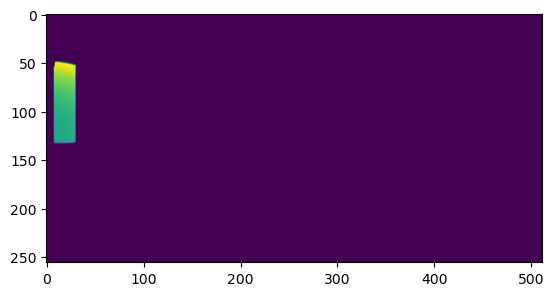

In [3]:
class NewRenderer(torch.nn.Module):
    def __init__(self, BS, sample_num=300, origin_height=2, realworld_scale=128, max_height=64, sample_total_length=128, ground=False):
        super(NewRenderer, self).__init__()
        self.BS, self.ground = BS, ground
        self.sample_num = sample_num
        self.max_height = max_height
        self.pano_direction = torch.from_numpy(self.get_original_coord()).unsqueeze(0).to('cuda')
        ##### get origin, sample point ,depth
        self.origin_height=origin_height       ## the height of photo taken in real world scale
        self.realworld_scale = realworld_scale  ## the real world scale corresponding to [-1,1] regular cooridinate
        self.sample_total_length = sample_total_length
        
        origin_z = torch.ones([self.BS,1])*(-1+(self.origin_height/(self.realworld_scale/2))) ### -1 is the loweast position in regular cooridinate
        ##### origin_z: which can be definition by origin height
        origin_H,origin_w = torch.zeros([self.BS,1]),torch.zeros([self.BS,1])
        
        origin = torch.cat([origin_w,origin_z,origin_H],dim=1).to('cuda')[:,None,None,:]  ## w,z,h, samiliar to NERF coordinate definition
        
        sample_len = ((torch.arange(self.sample_num)+1) / self.sample_num).to('cuda')
        ### sample_len:  For sample distance is fixed, so we can easily calculate sample len along a way by max length and sample number
        origin = origin[...,None]
        
        pano_direction = self.pano_direction[...,None] ### the direction has been normalized
        sample_len = sample_len[None,None,None,None,:]
        self.depth = sample_len * self.sample_total_length
        sample_point = origin + pano_direction * sample_len #0.0000],-0.8667],0.0000 w,z,h
        # x points right, y points up, z points backwards scene nerf
        voxel_low = -1
        voxel_max = -1 + self.max_height/(self.realworld_scale/2)  ### voxel highest space in normal space
        grid = sample_point.permute(0,4,1,2,3)[...,[0,2,1]] ### BS,NUM_point,W,H,3 
        grid[...,2]   = ((grid[...,2]-voxel_low)/(voxel_max-voxel_low))*2-1  ### grid_space change to sample space by scale the z space
        self.grid = grid.float()  ## [1, 300, 256, 512, 3]
    
    def get_original_coord(self):
        W,H  = 512, 256
        _y = np.repeat(np.array(range(W)).reshape(1,W), H, axis=0)
        _x = np.repeat(np.array(range(H)).reshape(1,H), W, axis=0).T
        _theta = (1 - 2 * (_x) / H) * np.pi/2 # latitude 
        _phi = math.pi*( - 0.5 - 2* (_y)/W )
        axis0 = (np.cos(_theta)*np.cos(_phi)).reshape(H, W, 1)
        axis1 = np.sin(_theta).reshape(H, W, 1) 
        axis2 = (-np.cos(_theta)*np.sin(_phi)).reshape(H, W, 1) 
        pano_direction = np.concatenate((axis0, axis1, axis2), axis=2)
        return pano_direction  
    
    def forward(self, voxel):
        if self.ground:
            voxel = torch.cat([torch.ones(voxel.size(0),1,voxel.size(2),voxel.size(3), device='cuda')*1000,voxel],1).to('cuda')
        
        alpha_grid = torch.nn.functional.grid_sample(voxel.unsqueeze(1), self.grid, align_corners=False)
        
        depth_sample = self.depth.permute(0,1,2,4,3).view(1,-1,self.sample_num,1)

        alpha_grid = alpha_grid.permute(0,3,4,2,1).view(self.BS,-1,self.sample_num)
        intv = self.sample_total_length/self.sample_num

        pano_size = (512, 256)
        sigma_delta = alpha_grid*intv # [B,HW,N]
        alpha = 1-(-sigma_delta).exp_() # [B,HW,N]
        T = (-torch.cat([torch.zeros_like(sigma_delta[...,:1]),sigma_delta[...,:-1]],dim=2).cumsum(dim=2)).exp_() # [B,HW,N]
        prob = (T*alpha)[...,None] # [B,HW,N,1]
        depth = (depth_sample*prob).sum(dim=2) # [B,HW,1]
        opacity = prob.sum(dim=2)
        depth = depth.permute(0,2,1).view(depth.size(0),-1,pano_size[1], pano_size[0])
        opacity = opacity.view(opacity.size(0),1,pano_size[1],pano_size[0])
        return depth, opacity
    
    
tt = NewRenderer(4, ground=False)
x = torch.zeros(4, 64, 256, 256).cuda()
x[:, :, 200:210, 100:120, ] = 1
depth, opa = tt(x)
plt.imshow(depth[0,0,...].cpu())

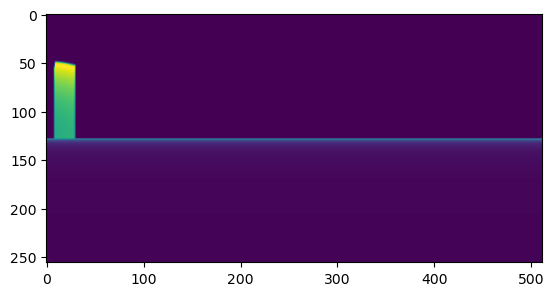

In [4]:
class PanoRenderer(nn.Module):
    def __init__(self, B, H, W, camera_height, max_height, plane_scale, total_sample_len, total_sample_num, use_ground) -> None:
        super().__init__()
        self.B, self.H, self.W = B, H, W
        self.camera_height, self.max_height = camera_height, max_height
        self.plane_scale = plane_scale
        self.total_sample_len, self.total_sample_num = total_sample_len, total_sample_num
        self.use_ground = use_ground
        
        pano_direction = self.__get_pano_direction()[None, None, ...].expand(self.B, -1, -1, -1, -1)
        origin_z = (-1 + (self.camera_height * 2 / self.plane_scale)) * torch.ones(self.B, 1)
        origin_x, origin_y = torch.zeros(self.B, 1), torch.zeros(self.B, 1)
        origin = torch.cat([origin_x, origin_y, origin_z], dim=-1)[:, None, None, None, :]

        sample_len = torch.arange(1, self.total_sample_num+1) / self.total_sample_num
        sample_len = sample_len.view(1, -1, 1, 1, 1)
        self.depth = (sample_len * self.total_sample_len).permute(0, 2, 3, 4, 1)
        
        sample_points = origin + sample_len * pano_direction
        grid_min, grid_max = -1, -1 + self.max_height * 2 / self.plane_scale
        self.grid = sample_points
        self.grid[...,2]   = ((sample_points[...,2]-grid_min)/(grid_max - grid_min)) * 2 - 1
        
    def __get_pano_direction(self):
        _x, _y = torch.meshgrid(torch.linspace(0, 1, self.H), torch.linspace(0, 1, self.W), indexing='ij')
        lat = (0.5 - _x) * torch.pi
        lon = (-0.5 - 2 * _y) * torch.pi
        axis1 = torch.cos(lat) * torch.cos(lon)
        axis2 = -torch.cos(lat) * torch.sin(lon)
        axis3 = torch.sin(lat)
        pano_direction = torch.concatenate([axis1[..., None], axis2[...,None], axis3[..., None]], dim=-1)
        return pano_direction
    
    def forward(self, voxel):
        voxel = torch.cat([torch.ones(voxel.size(0),1,voxel.size(2),voxel.size(3))*1000,voxel], dim=1) if self.use_ground else voxel
        
        alpha_grid = torch.nn.functional.grid_sample(voxel.unsqueeze(1), self.grid, align_corners=False)
        
        depth_sample = self.depth.permute(0,1,2,4,3).view(1,-1,self.total_sample_num,1)

        alpha_grid = alpha_grid.permute(0,3,4,2,1).view(self.B,-1,self.total_sample_num)
        intv = self.total_sample_len / self.total_sample_num

        sigma_delta = alpha_grid*intv # [B,HW,N]
        alpha = 1-(-sigma_delta).exp_() # [B,HW,N]
        T = (-torch.cat([torch.zeros_like(sigma_delta[...,:1]),sigma_delta[...,:-1]],dim=2).cumsum(dim=2)).exp_() # [B,HW,N]
        prob = (T*alpha)[...,None] # [B,HW,N,1]
        depth = (depth_sample*prob).sum(dim=2) # [B,HW,1]
        opacity = prob.sum(dim=2)
        depth = depth.permute(0,2,1).view(self.B,-1,self.H, self.W)
        opacity = opacity.view(self.B,-1,self.H, self.W)
        return depth, opacity
    

t = PanoRenderer(4, 256, 512, 2, 64, 128, 64, 300, True)
x = torch.zeros(4, 64, 256, 256)
x[:, :, 200:210, 100:120, ] = 1
depth, opa = t(x)
plt.imshow(depth[0,0,...].cpu())

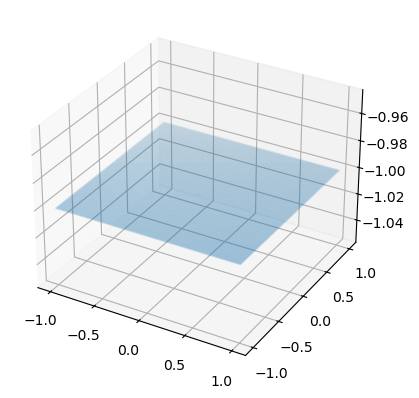

0.21333333333333335


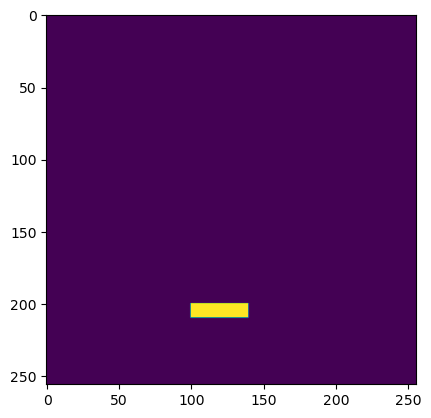

In [8]:
class HeightRenderer(torch.nn.Module):
    def __init__(self, BS, W=256, H=256, total_sample_num=300, origin_height=64, max_height=64, realworld_scale=128, total_sample_len=64, ground=False):
        super(HeightRenderer, self).__init__()
        self.W, self.H = W, H
        self.BS, self.ground = BS, ground
        self.total_sample_num = total_sample_num
        self.origin_height, self.max_height = origin_height, max_height
        self.realworld_scale = realworld_scale
        self.total_sample_len = total_sample_len
        
        _x = torch.linspace(-1, 1, self.W)
        _y = torch.linspace(-1, 1, self.H)
        _z = torch.linspace(-1, 1, self.total_sample_num)
        xv, yv, zv = torch.meshgrid(_x, _y, _z, indexing='xy')
        grid = torch.cat([xv[..., None], yv[..., None], zv[..., None]], dim=-1)[None,...].expand(self.BS, -1, -1, -1, -1)        
        self.grid = grid.permute(0, 3, 1, 2, 4).to('cuda')  # B Z X Y 3
        sample_len = ((torch.arange(self.total_sample_num)+1)*(self.total_sample_len/self.total_sample_num)).to("cuda")
        self.depth = sample_len[None,None,None,None,:]
        
    def forward(self, density):
        if self.ground:
            density = torch.cat([torch.ones(density.size(0),1,density.size(2),density.size(3), device='cuda')*1000,density],1).to('cuda')
        alpha_grid = torch.nn.functional.grid_sample(density.unsqueeze(1), self.grid, align_corners=True)
        depth_sample = self.depth.permute(0,1,2,4,3).view(1,-1,self.total_sample_num,1)
        alpha_grid = alpha_grid.permute(0,3,4,2,1).view(self.BS,-1,self.total_sample_num)
        intv = self.total_sample_len/self.total_sample_num
        print(intv)
        sigma_delta = alpha_grid*intv
        alpha = 1-(-sigma_delta).exp_()
        T = (-torch.cat([torch.zeros_like(sigma_delta[...,:1]),sigma_delta[...,:-1]],dim=2).cumsum(dim=2)) .exp_()
        prob = (T*alpha)[...,None]
        depth = (depth_sample*prob).sum(dim=2) # [B,HW,1]
        height = depth.permute(0,2,1).view(depth.size(0),-1,self.W, self.H)
        return height


p_render = PanoRenderer(4, 256, 512, 2, 64, 128, 64, 300, True)
h_render = HeightRenderer(4, )
x = torch.zeros(4, 64, 256, 256)
x[:, :, 200:210, 100:140] = 1
depth, opa = p_render(x)
height = h_render(x.cuda())

plt.imshow(height[0, 0, ...].cpu())
plt.show()